<a id = 'home' ></a>

# Multiple Offense Analysis - Updated

## Content

### [**Submission Summary**](#ss) <a href = '#ss'></a>

1. [**Libraries and Analyzing the Data**](#Libraries) <a href = '#Libraries'></a>
2. [**Converting Data and Analyzing Null Values**](#convert) <a href = '#convert'></a>
3. [**Initial Plots and Observations**](#plot) <a href = '#plot'></a>
    - **Correlation Plot**
        - Two pairs with high correlation appear: (X_6 & X_7) and (X_10 & X_12)
        - X_6 & X_7 relation to be used later in the analysis by either FE or elimination
        - X_10 & X_12 relation to be used for one of the methods of imputation for X_12
    - [**Checking Target Variable Frequencies**](#target) <a href = '#target'></a>
        - MULTIPLE_OFFENSE = 0 is <5% of the total observations
        - Noted for treatment for Class Imbalance
    - [**Frequencies of X_ variables**](#xvar) <a href = '#xvar'></a>
        - X_2 & X_3 have same set of counts but a part of the set belonging to different values
        - X_6 & X_7 have same set of counts but a part of the set belonging to different values
        - Spikes observed maybe in line with the X_ variables indicating logging parameters
4. [**Imputation**](#impute) <a href = '#impute'></a>
    - [**Imputing X_12 with value 1**](#impute1) <a href = '#impute1'></a>
        -  Analyzing this imputation in line with X_10 and most occuring value
5. [**Data Preparation**](#prep) <a href = '#prep'></a>
    - [**Resampling - Upsample minority class**](#upmin) <a href = '#upmin'></a>
    - [**Resampling - Downsample majority class**](#downmaj) <a href = '#downmaj'></a>
6. [**Model Building**](#model) <a href = '#model'></a>
    - [**A. Logistic Regression**](#logreg) <a href = '#logreg'></a>
    - [**B. Random Forest**](#rf) <a href = '#rf'></a>
        -  [**RF with Grid Search and CV**](#rfgs) <a href = '#rfgs'></a>
        -  [**RF with Grid Search and CV on Upsampled Data**](#rfgs_up) <a href = '#rfgs_up'></a>
        -  [**RF with Grid Search and CV on Downsampled Data**](#rfgs_down) <a href = '#rfgs_down'></a>
        -  [**Ensemble of RFs on Up and Down - sampled Data**](#ens) <a href = '#ens'></a>       
    - [**C. LGBM**](#lgbm) <a href = '#lgbm'></a>  
        -  [**Final Params**](#fp) <a href = '#fp'></a>   

## Submission Summary <a id = 'ss' ></a>
- Submission 1: Logistic Regression       - **56.07**
- Submission 2: Random Forest             - **88.85**
- Submission 3: Random Forest Grid Search - **77.99**
    - criterion': 'entropy',  'max_depth': 10,  'max_features': 'auto',  'n_estimators': 100
- Submission 4: Random Forest Grid Search - **84.29**
    - 'criterion': 'gini',  'max_depth': 16,  'max_features': 'auto', 'n_estimators': 80
- Submission 5: Random Forest on Upsampled data - **92.95**
    - criterion='gini', max_depth=16, max_features='auto', n_estimators= 80
- Submission 6: Random Forest with GS & CV on Upsampled data - **97.46**  
    - criterion='entropy', max_depth=10, max_features='auto', n_estimators= 150
- Submission 7: Random Forest with GS & CV on Upsampled data - **97.46**  
    - criterion='gini', max_depth=16, max_features='auto', n_estimators= 130
- Submission 8: Random Forest with GS & CV on Downsampled data - **94.67**  
    - criterion='gini', max_depth=12, max_features='auto', n_estimators= 130   
- Submission 9: Ensemble of RFs on Up and Down - sampled data - **84.91**    
- Submission 10: Random Forest on Upsampled data with new set of Car var defined - **95.14**   
- Submission 11: Random Forest Grid Search with new set of Car var defined - **93.83**
    - 'criterion': 'gini',  'max_depth': 16,  'max_features': 'auto', 'n_estimators': 80
- Submission 12: Random Forest with GS & CV on Upsampled data with new set of Car var defined - **98.35**  
    - criterion='entropy', max_depth=10, max_features='auto', n_estimators= 100
- Submission 13: Random Forest with GS & CV on Upsampled data with new set of Car var defined - **97.86**  
    - criterion='entropy', max_depth=10, max_features='auto', n_estimators= 120
- Submission 14: LGBM Randomized Search on Upsampled data with new set of Car var defined - **99.41**  
    - hard coded bagging_fraction and feature_fraction
- Submission 15: LGBM Randomized Search on Upsampled data with new set of Car var defined - **99.56**  
    - with GS on bagging_fraction and feature_fraction
    - for the set of hyperparameters please refer to [final_params](#fp) <a href = '#fp'></a> 

## 1. Libraries and Analyzing the Data <a id = 'Libraries' ></a>

[Home](#home) <a href = '#home'></a>

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
traindf = pd.read_csv('Train.csv')
traindf.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [3]:
testdf = pd.read_csv('Test.csv')
testdf.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


In [4]:
ss = pd.read_csv('sample_submission.csv')
ss.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,0
2,.,.
3,.,.
4,CR_196089,1


In [5]:
traindf.dtypes

INCIDENT_ID          object
DATE                 object
X_1                   int64
X_2                   int64
X_3                   int64
X_4                   int64
X_5                   int64
X_6                   int64
X_7                   int64
X_8                   int64
X_9                   int64
X_10                  int64
X_11                  int64
X_12                float64
X_13                  int64
X_14                  int64
X_15                  int64
MULTIPLE_OFFENSE      int64
dtype: object

In [6]:
testdf.dtypes

INCIDENT_ID     object
DATE            object
X_1              int64
X_2              int64
X_3              int64
X_4              int64
X_5              int64
X_6              int64
X_7              int64
X_8              int64
X_9              int64
X_10             int64
X_11             int64
X_12           float64
X_13             int64
X_14             int64
X_15             int64
dtype: object

## 2. Converting Data and Analyzing Null Values <a id = 'convert' ></a>
- No need to drop column/s based on existing null values

[Home](#home) <a href = '#home'></a>

#### Converting DATE to Date

In [7]:
traindf['DATE'] =pd.to_datetime(traindf.DATE, format = '%d-%b-%y')
testdf['DATE'] = pd.to_datetime(testdf.DATE, format = '%d-%b-%y')
print('train set ' , traindf.DATE.dtypes)
print('test set ',testdf.DATE.dtypes)

train set  datetime64[ns]
test set  datetime64[ns]


#### Converting target variable to Categorical

In [8]:
# traindf['MULTIPLE_OFFENSE'] = pd.Categorical(traindf.MULTIPLE_OFFENSE)
# traindf['MULTIPLE_OFFENSE'].dtypes

CategoricalDtype(categories=[0, 1], ordered=False)

In [9]:
# traindf.dtypes

INCIDENT_ID                 object
DATE                datetime64[ns]
X_1                          int64
X_2                          int64
X_3                          int64
X_4                          int64
X_5                          int64
X_6                          int64
X_7                          int64
X_8                          int64
X_9                          int64
X_10                         int64
X_11                         int64
X_12                       float64
X_13                         int64
X_14                         int64
X_15                         int64
MULTIPLE_OFFENSE          category
dtype: object

#### Checking column wise NAs for traindf

In [8]:
NA_col = pd.DataFrame(traindf.isna().sum(), columns = ['NA_Count'])
NA_col['%_of_NA'] = (NA_col.NA_Count/len(traindf))*100
NA_col.sort_values(by = ['%_of_NA'], ascending = False, na_position = 'first')

,NA_Count,%_of_NA
X_12,182,0.762911
INCIDENT_ID,0,0.000000
DATE,0,0.000000
X_15,0,0.000000
X_14,0,0.000000
X_13,0,0.000000
X_11,0,0.000000
X_10,0,0.000000
X_9,0,0.000000
X_8,0,0.000000


#### Checking row wise NAs for traindf

In [9]:
NA_row = pd.DataFrame(traindf.isna().sum(axis=1), columns = ['NA_rw_count'])
NA_row['%_of_rw_NA'] = (NA_row.NA_rw_count/len(traindf))*100
NA_row.sort_values(by = ['%_of_rw_NA'], ascending = False, na_position = 'first').head(10)

,NA_rw_count,%_of_rw_NA
11928,1,0.004192
22017,1,0.004192
21197,1,0.004192
16051,1,0.004192
2679,1,0.004192
15323,1,0.004192
14597,1,0.004192
21961,1,0.004192
4843,1,0.004192
12351,1,0.004192


#### Checking column wise NAs for test

In [10]:
NA_col = pd.DataFrame(testdf.isna().sum(), columns = ['NA_Count'])
NA_col['%_of_NA'] = (NA_col.NA_Count/len(testdf))*100
NA_col.sort_values(by = ['%_of_NA'], ascending = False, na_position = 'first')

,NA_Count,%_of_NA
X_12,127,0.798591
INCIDENT_ID,0,0.000000
X_8,0,0.000000
X_14,0,0.000000
X_13,0,0.000000
X_11,0,0.000000
X_10,0,0.000000
X_9,0,0.000000
X_7,0,0.000000
DATE,0,0.000000


#### Checking row wise NAs for test

In [11]:
NA_row = pd.DataFrame(testdf.isna().sum(axis=1), columns = ['NA_rw_count'])
NA_row['%_of_rw_NA'] = (NA_row.NA_rw_count/len(testdf))*100
NA_row.sort_values(by = ['%_of_rw_NA'], ascending = False, na_position = 'first').head()

,NA_rw_count,%_of_rw_NA
0,1,0.006288
5871,1,0.006288
2223,1,0.006288
869,1,0.006288
6166,1,0.006288


## 3. Initial Plots and Observations <a id = 'plot' ></a>

[Home](#home) <a href = '#home'></a>

#### Correlation Plot
- Two pairs with high correlation appear: (X_6 & X_7) and (X_10 & X_12)
- X_6 & X_7 relation to be used later in the analysis by either FE or elimination
- X_10 & X_12 relation to be used for one of the methods of imputation for X_12

In [12]:
cor = traindf[['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15']]

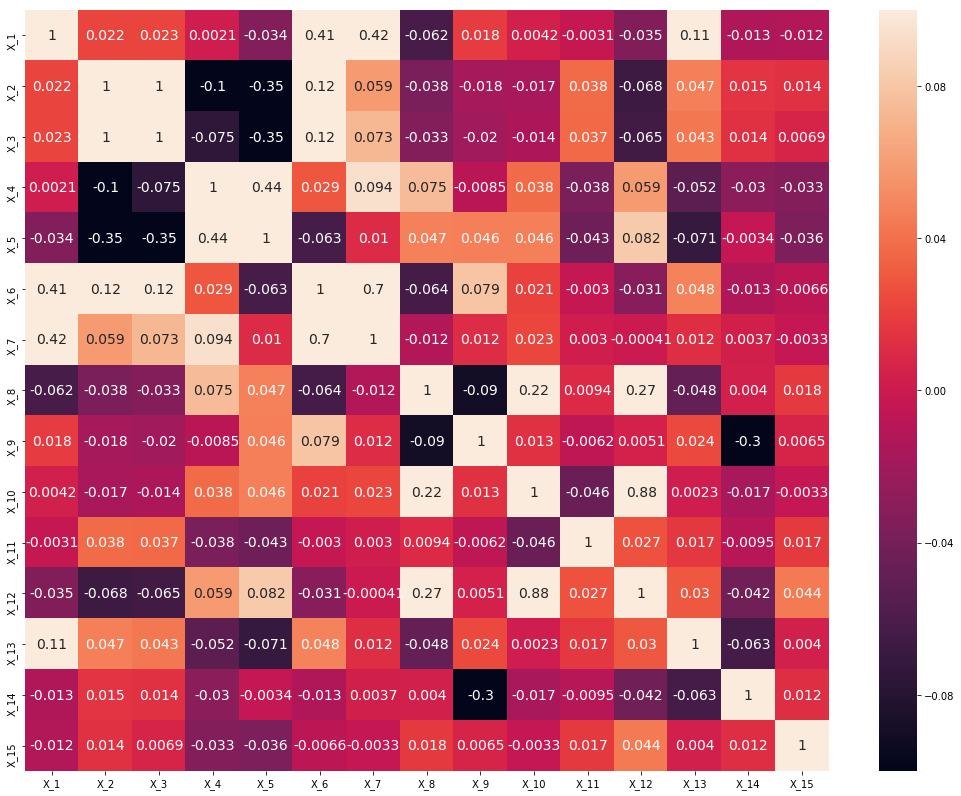

In [13]:
plt.figure(figsize = (18,14))
sns.heatmap(cor.corr(), vmin=cor.values.min(), vmax=1, annot=True, annot_kws={"size":14}, square = False)
plt.show()

#### Checking Target Variable Frequencies <a id = 'target' ></a>
- MULTIPLE_OFFENSE = 0 is <5% of the total observations
- Noted for treatment for Class Imbalance

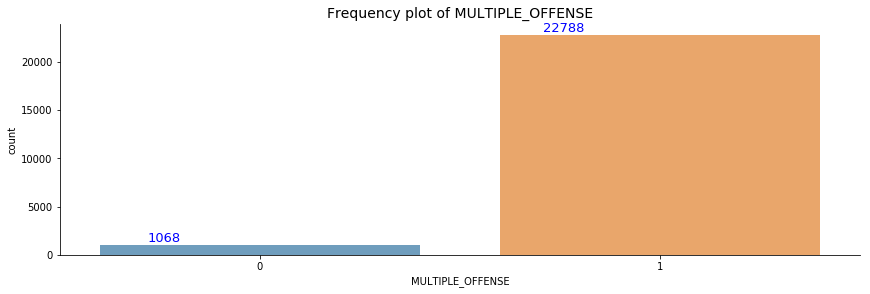

In [14]:
sns.catplot('MULTIPLE_OFFENSE', data= traindf, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['MULTIPLE_OFFENSE'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of MULTIPLE_OFFENSE', fontsize = 14, color = 'black')
plt.show()

#### Frequency Plots of X_ variables <a id = 'xvar' ></a>

[Home](#home) <a href = '#home'></a>

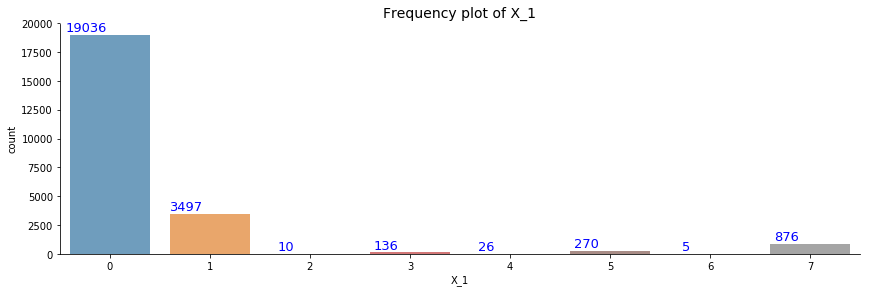

In [15]:
sns.catplot('X_1', data= traindf, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_1'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_1', fontsize = 14, color = 'black')
plt.show()

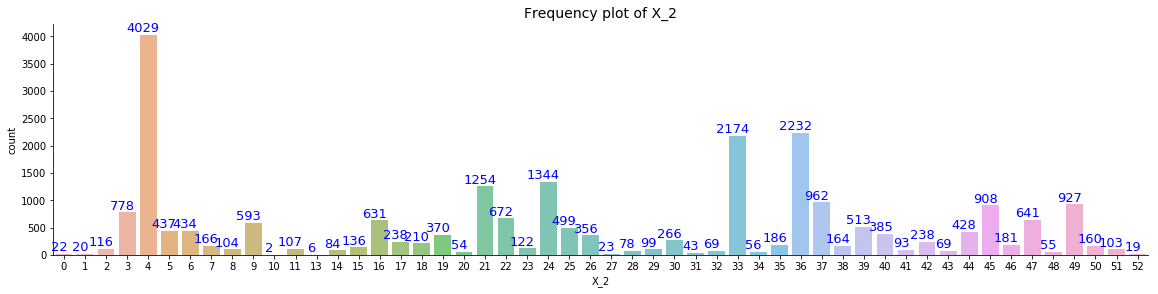

In [16]:
sns.catplot('X_2', data= traindf, kind='count', alpha=0.7, height=4, aspect= 4)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_2'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_2', fontsize = 14, color = 'black')
plt.show()

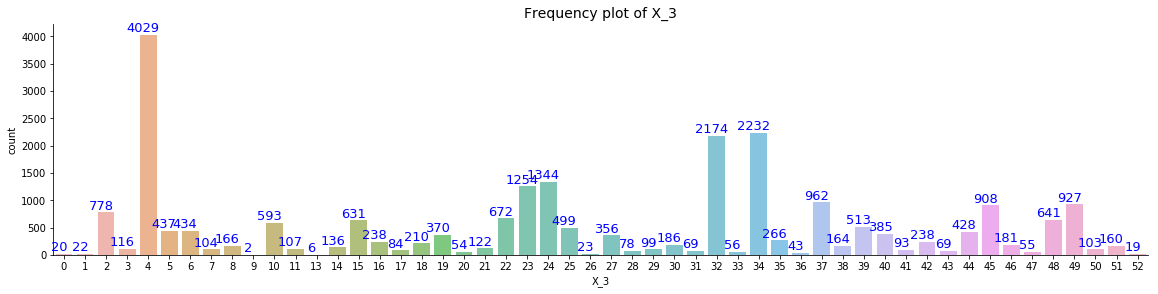

In [17]:
sns.catplot('X_3', data= traindf, kind='count', alpha=0.7, height=4, aspect= 4)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_3'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_3', fontsize = 14, color = 'black')
plt.show()

[Home](#home) <a href = '#home'></a>

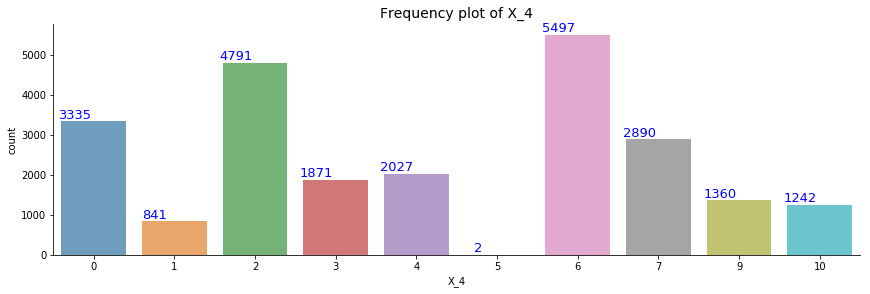

In [18]:
sns.catplot('X_4', data= traindf, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_4'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_4', fontsize = 14, color = 'black')
plt.show()

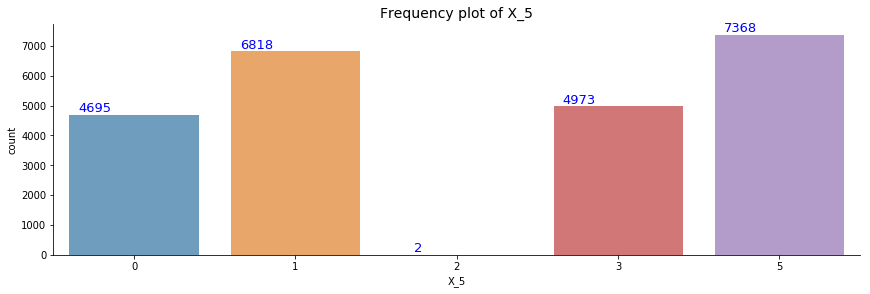

In [19]:
sns.catplot('X_5', data= traindf, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_5'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_5', fontsize = 14, color = 'black')
plt.show()

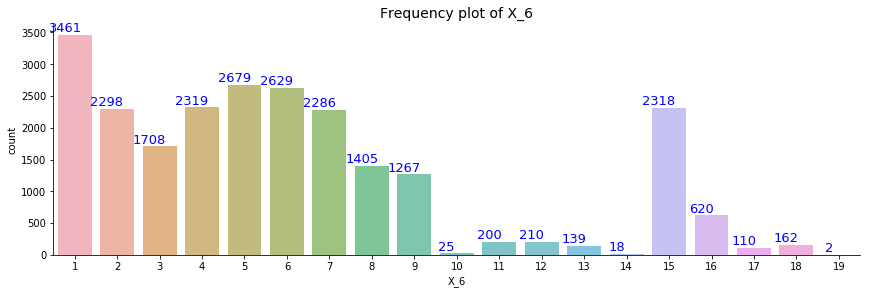

In [20]:
sns.catplot('X_6', data= traindf, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_6'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_6', fontsize = 14, color = 'black')
plt.show()

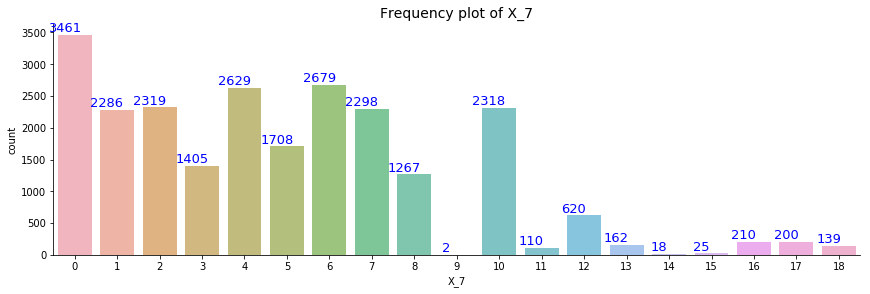

In [21]:
sns.catplot('X_7', data= traindf, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_7'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_7', fontsize = 14, color = 'black')
plt.show()

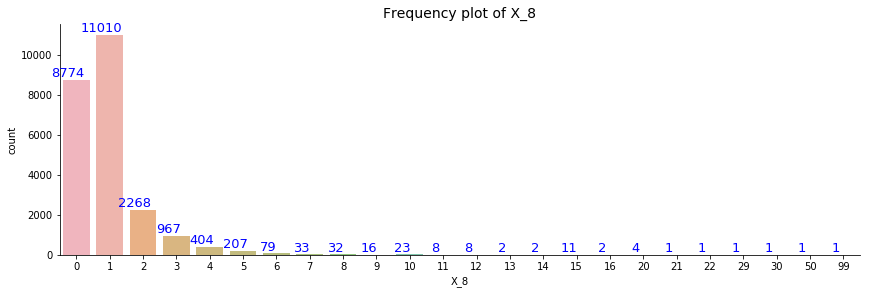

In [22]:
sns.catplot('X_8', data= traindf, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_8'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_8', fontsize = 14, color = 'black')
plt.show()

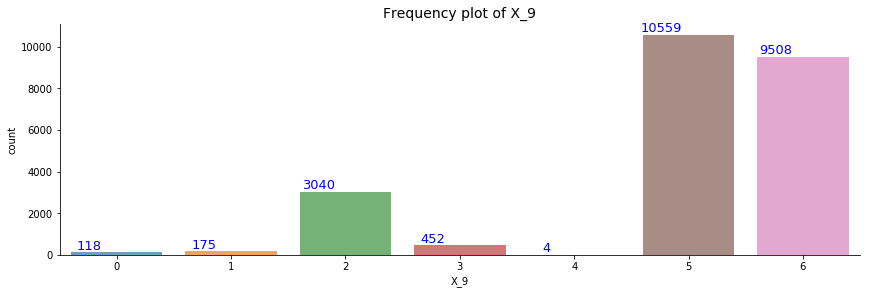

In [23]:
sns.catplot('X_9', data= traindf, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_9'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_9', fontsize = 14, color = 'black')
plt.show()

[Home](#home) <a href = '#home'></a>

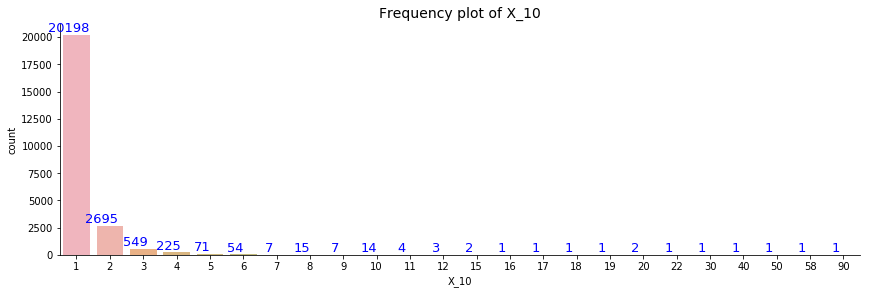

In [24]:
sns.catplot('X_10', data= traindf, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_10'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_10', fontsize = 14, color = 'black')
plt.show()

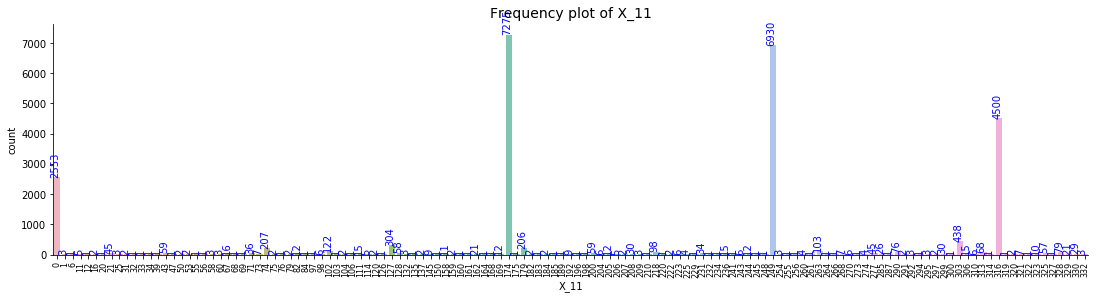

In [25]:
sns.catplot('X_11', data= traindf, kind='count', alpha=0.7, height=4, aspect= 3.8)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_11'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=10, color='blue',ha='center',  va='bottom', rotation = 90)
plt.title('Frequency plot of X_11', fontsize = 14, color = 'black')

plt.tick_params(axis='x', rotation = 90,  labelsize = 8)
plt.show()

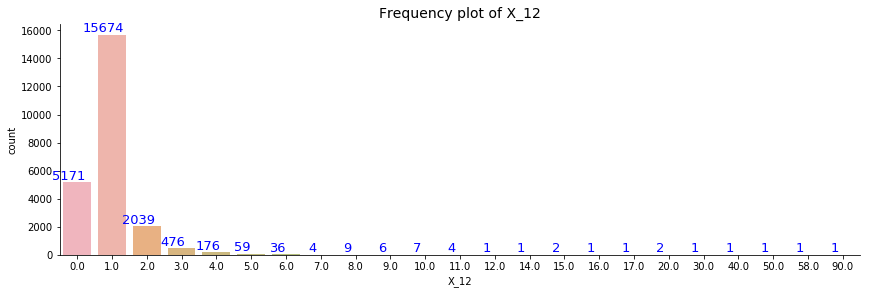

In [26]:
sns.catplot('X_12', data= traindf, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_12'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_12', fontsize = 14, color = 'black')
plt.show()

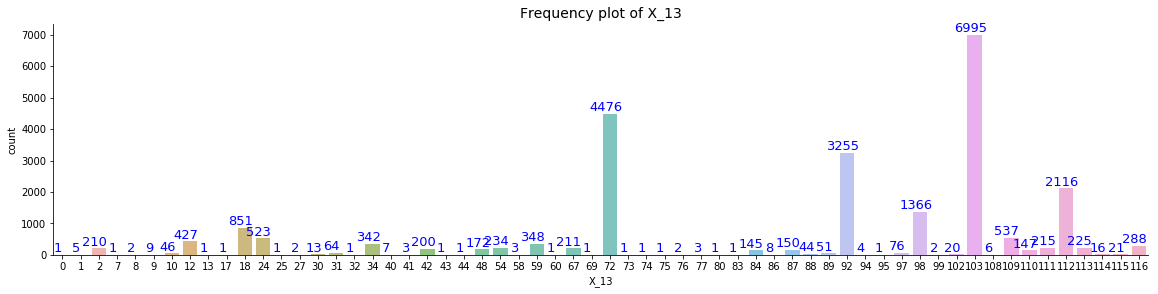

In [27]:
sns.catplot('X_13', data= traindf, kind='count', alpha=0.7, height=4, aspect= 4)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_13'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_13', fontsize = 14, color = 'black')
plt.show()

[Home](#home) <a href = '#home'></a>

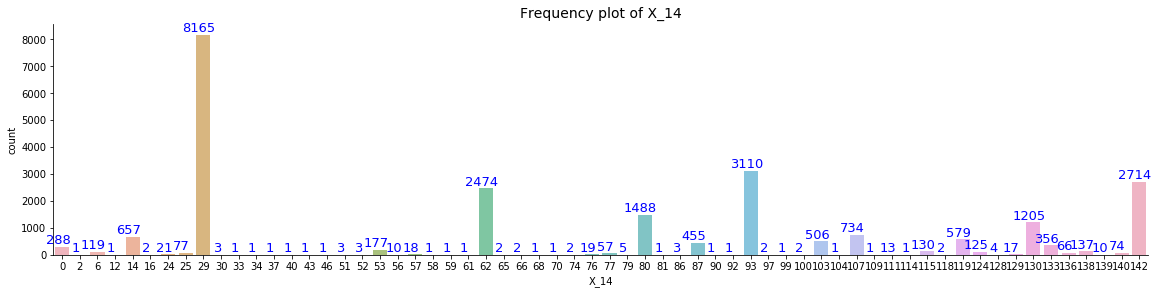

In [28]:
sns.catplot('X_14', data= traindf, kind='count', alpha=0.7, height=4, aspect= 4)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_14'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_14', fontsize = 14, color = 'black')
plt.show()

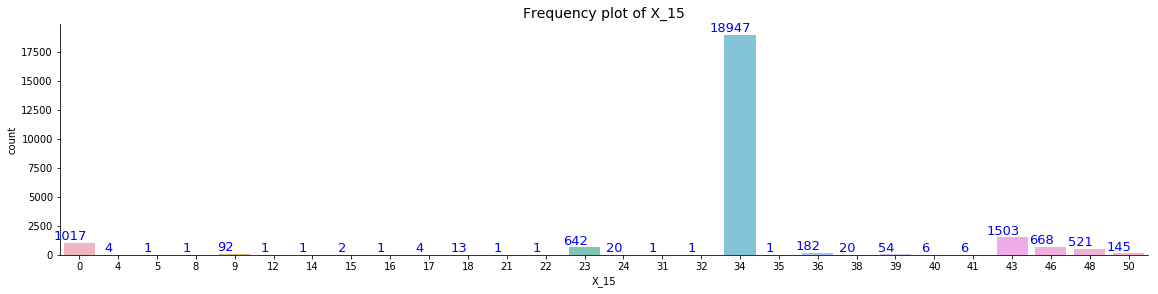

In [29]:
sns.catplot('X_15', data= traindf, kind='count', alpha=0.7, height=4, aspect= 4)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = traindf['X_15'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of X_15', fontsize = 14, color = 'black')
plt.show()

## 4. Imputation <a id = 'impute' ></a>

[Home](#home) <a href = '#home'></a>

#### Analyzing X_10 and X_12 for Train data

In [30]:
train_X_10_12 = traindf[["DATE", "X_10","X_12","MULTIPLE_OFFENSE"]]
train_X_10_12.head()

,DATE,X_10,X_12,MULTIPLE_OFFENSE
0,2004-07-04,1,1.0,0
1,2017-07-18,1,1.0,1
2,2017-03-15,1,1.0,1
3,2009-02-13,1,1.0,1
4,2005-04-13,1,0.0,1


In [31]:
null = train_X_10_12[train_X_10_12['X_12'].isna()]
null.DATE.min()

Timestamp('2017-01-04 00:00:00')

In [32]:
train_X_10_12 = train_X_10_12[train_X_10_12["DATE"].isin(pd.date_range("2016-07-01", "2030-01-01"))]
train_X_10_12 = train_X_10_12.set_index('DATE')
train_X_10_12.head()

,X_10,X_12,MULTIPLE_OFFENSE
DATE,,,
2017-07-18,1,1.0,1
2017-03-15,1,1.0,1
2016-08-21,1,1.0,1
2018-01-09,3,3.0,1
2017-07-25,1,0.0,1


In [33]:
train_X_10_12 = train_X_10_12 .assign(missing= np.nan)
train_X_10_12.missing[train_X_10_12['X_12'].isna()] = train_X_10_12.X_10
train_X_10_12.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2125 entries, 2017-07-18 to 2018-10-16
Data columns (total 4 columns):
X_10                2125 non-null int64
X_12                1943 non-null float64
MULTIPLE_OFFENSE    2125 non-null int64
missing             182 non-null float64
dtypes: float64(2), int64(2)
memory usage: 83.0 KB


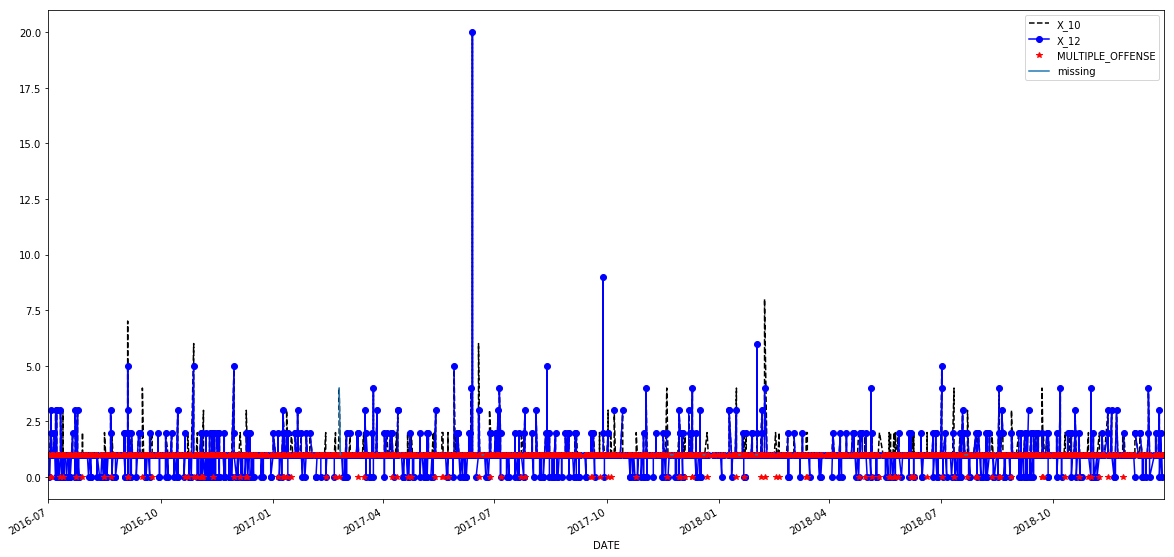

In [34]:
train_X_10_12.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))

In [35]:
train_X_10_12.X_12.value_counts()

1.0     1421
0.0      291
2.0      173
3.0       37
4.0       12
5.0        6
6.0        1
9.0        1
20.0       1
Name: X_12, dtype: int64

#### Analyzing X_10 and X_12 for Test data

In [36]:
test_X_10_12 = testdf[["DATE", "X_10","X_12"]]
test_X_10_12.head()

,DATE,X_10,X_12
0,2018-02-01,1,NaN
1,2004-03-05,1,0.0
2,2018-01-27,1,1.0
3,2006-08-18,1,1.0
4,2011-10-31,1,0.0


In [37]:
null = test_X_10_12[test_X_10_12['X_12'].isna()]
null.DATE.min()

Timestamp('2017-01-04 00:00:00')

In [38]:
test_X_10_12 = test_X_10_12[test_X_10_12["DATE"].isin(pd.date_range("2016-07-01", "2030-01-01"))]
test_X_10_12 = test_X_10_12.set_index('DATE')
test_X_10_12.head()

,X_10,X_12
DATE,,
2018-02-01,1,NaN
2018-01-27,1,1.0
2017-05-31,1,NaN
2017-08-04,1,1.0
2016-08-23,1,0.0


In [39]:
test_X_10_12 = test_X_10_12 .assign(missing= np.nan)
test_X_10_12.missing[test_X_10_12['X_12'].isna()] = test_X_10_12.X_10
test_X_10_12.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1374 entries, 2018-02-01 to 2017-06-29
Data columns (total 3 columns):
X_10       1374 non-null int64
X_12       1247 non-null float64
missing    127 non-null float64
dtypes: float64(2), int64(1)
memory usage: 42.9 KB


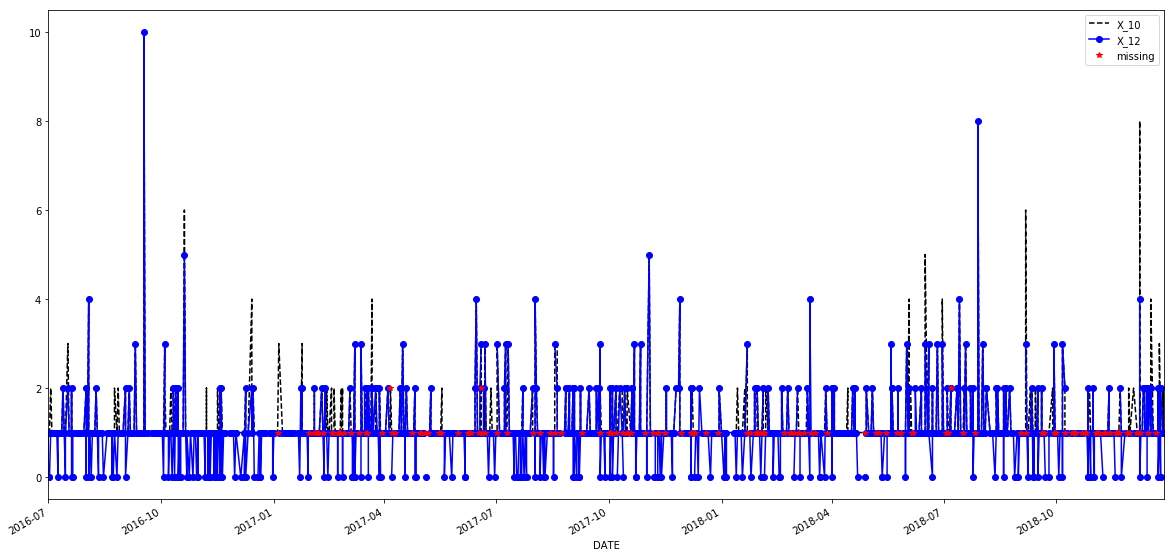

In [40]:
test_X_10_12.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))

In [41]:
test_X_10_12.X_12.value_counts()

1.0     917
0.0     170
2.0     123
3.0      26
4.0       7
5.0       2
10.0      1
8.0       1
Name: X_12, dtype: int64

### Imputing X_12 with value 1 <a id = 'impute1' ></a>

[Home](#home) <a href = '#home'></a>

In [42]:
traindf['X_12'] = traindf['X_12'].fillna(1)
traindf.isna().sum()

INCIDENT_ID         0
DATE                0
X_1                 0
X_2                 0
X_3                 0
X_4                 0
X_5                 0
X_6                 0
X_7                 0
X_8                 0
X_9                 0
X_10                0
X_11                0
X_12                0
X_13                0
X_14                0
X_15                0
MULTIPLE_OFFENSE    0
dtype: int64

In [43]:
testdf['X_12'] = testdf['X_12'].fillna(1)
testdf.isna().sum()

INCIDENT_ID    0
DATE           0
X_1            0
X_2            0
X_3            0
X_4            0
X_5            0
X_6            0
X_7            0
X_8            0
X_9            0
X_10           0
X_11           0
X_12           0
X_13           0
X_14           0
X_15           0
dtype: int64

## 5. Data Preparation <a id = 'prep' ></a>

[Home](#home) <a href = '#home'></a>

#### Checking for Columns with either single value or all unique values

In [44]:
for i in traindf.columns:
    if traindf[i].nunique() == 1:
        print('Train: With only 1 unique value: ', i)
    if traindf[i].nunique() == traindf.shape[0]:
        print('Train: With all unique value: ', i)

for i in testdf.columns:
    if testdf[i].nunique() == 1:
        print('Test: With only 1 unique value: ', i)
    if testdf[i].nunique() == testdf.shape[0]:
        print('Test: With all unique value: ', i)

Train: With all unique value:  INCIDENT_ID
Test: With all unique value:  INCIDENT_ID


#### Dropping INCIDENT_ID

In [45]:
train = traindf.copy().drop('INCIDENT_ID', axis = 1)
test = testdf.copy().drop('INCIDENT_ID', axis = 1)

#### Extracting information from DATE column before dropping

In [46]:
train['Year'] = train['DATE'].dt.year
train['Month'] = train['DATE'].dt.month
train['Day'] = train['DATE'].dt.weekday_name
train.head()

,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,Year,Month,Day
0,2004-07-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0,2004,7,Sunday
1,2017-07-18,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1,2017,7,Tuesday
2,2017-03-15,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1,2017,3,Wednesday
3,2009-02-13,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1,2009,2,Friday
4,2005-04-13,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1,2005,4,Wednesday


In [47]:
test['Year'] = test['DATE'].dt.year
test['Month'] = test['DATE'].dt.month
test['Day'] = test['DATE'].dt.weekday_name
test.head()

,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Year,Month,Day
0,2018-02-01,0,30,35,7,3,6,4,0,5,1,174,1.0,72,119,23,2018,2,Thursday
1,2004-03-05,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34,2004,3,Friday
2,2018-01-27,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34,2018,1,Saturday
3,2006-08-18,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34,2006,8,Friday
4,2011-10-31,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43,2011,10,Monday


In [48]:
train = train.drop('DATE', axis = 1)
test = test.drop('DATE', axis = 1)

#### Defining Categorical Variables for Label Encoding

In [49]:
col_train = train.columns
col_test = test.columns

In [50]:
# Changing variables with 10 or less unique values
l1 = []
for i in col_train:
    if train[i].nunique() <= 10:
        l1.append(i)
               
l1.remove('MULTIPLE_OFFENSE')

In [51]:
l2 = []
for i in col_test:
    if test[i].nunique() <= 10:
        l2.append(i)

In [52]:
# Checking the columns in train and test are same or not
df = pd.DataFrame(l1, columns = ['train'])
df['test'] = pd.DataFrame(l2)
df

,train,test
0,X_1,X_1
1,X_4,X_4
2,X_5,X_5
3,X_9,X_9
4,Day,Day


In [53]:
train[l1] = train[l1].apply(lambda x: x.astype('category'), axis=0)
test[l2] = test[l2].apply(lambda x: x.astype('category'), axis=0)
print('train dtypes:')
print(train[l1].dtypes)
print('======================================')
print('test dtypes:')
print(test[l1].dtypes)

train dtypes:
X_1    category
X_4    category
X_5    category
X_9    category
Day    category
dtype: object
test dtypes:
X_1    category
X_4    category
X_5    category
X_9    category
Day    category
dtype: object


In [54]:
cols = train.drop('MULTIPLE_OFFENSE', axis=1).columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

['X_5', 'X_9', 'X_4', 'Day', 'X_1']

In [55]:
for usecol in cat_cols:
    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+ test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1
    
    train[usecol] = train[usecol].replace(np.nan, '').astype('int').astype('category')
    test[usecol]  = test[usecol].replace(np.nan, '').astype('int').astype('category')

### Resampling - Upsample minority class <a id = 'upmin' ></a>

[Home](#home) <a href = '#home'></a>

In [56]:
train.MULTIPLE_OFFENSE.value_counts()

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64

In [57]:
# Separating majority and minority classes
train_majority = train[train.MULTIPLE_OFFENSE==1]
train_minority = train[train.MULTIPLE_OFFENSE==0]

In [58]:
# Resampling the minority levels to match the majority level
# Upsample minority class
from sklearn.utils import resample
train_minority_upsampled = resample(train_minority, 
                                 replace=True,       # sample with replacement
                                 n_samples=22788,    # to match majority class
                                 random_state= 303)  # reproducible results
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])
 
# Display new class counts
train_upsampled.MULTIPLE_OFFENSE.value_counts()

1    22788
0    22788
Name: MULTIPLE_OFFENSE, dtype: int64

### Resampling - Downsample majority class <a id = 'downmaj' ></a>

[Home](#home) <a href = '#home'></a>

In [59]:
# Resampling the majority levels to match the minority level
# Downsample majority class
from sklearn.utils import resample
train_majority_downsampled = resample(train_majority, 
                                 replace=True,       # sample with replacement
                                 n_samples=1068,    # to match minority class
                                 random_state= 303)  # reproducible results
 
# Combine majority class with upsampled minority class
train_downsampled = pd.concat([train_majority_downsampled, train_minority])
 
# Display new class counts
train_downsampled.MULTIPLE_OFFENSE.value_counts()

1    1068
0    1068
Name: MULTIPLE_OFFENSE, dtype: int64

In [60]:
X = train.drop('MULTIPLE_OFFENSE', axis = 1)
y = train['MULTIPLE_OFFENSE']

#### For the upsampled data

In [61]:
Xs = train_upsampled.drop('MULTIPLE_OFFENSE', axis = 1)
ys = train_upsampled['MULTIPLE_OFFENSE']

#### For the downsampled data

In [62]:
Xsd = train_downsampled.drop('MULTIPLE_OFFENSE', axis = 1)
ysd = train_downsampled['MULTIPLE_OFFENSE']

## 6. Model Building <a id = 'model' ></a>

[Home](#home) <a href = '#home'></a>

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, random_state = 42)

In [64]:
Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs, ys, test_size=0.3, random_state = 42)

In [65]:
Xsd_train, Xsd_val, ysd_train, ysd_val = train_test_split(Xsd, ysd, test_size=0.3, random_state = 42)

### A. Logistic Regression <a id = 'logreg' ></a>

In [102]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [103]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [104]:
predictions = logreg.predict(X_val)

In [105]:
confusion_matrix(y_val, predictions)

array([[  44,  301],
       [  30, 6782]], dtype=int64)

In [106]:
recall_score(y_val, predictions)

0.9955960070463887

In [107]:
test['MULTIPLE_OFFENSE'] = logreg.predict(test)

In [108]:
test.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Year,Month,Day,MULTIPLE_OFFENSE
0,1,30,35,9,4,6,4,0,6,1,174,1.0,72,119,23,2018,2,5,1
1,1,44,44,2,4,7,1,4,7,1,316,0.0,12,29,34,2004,3,1,1
2,1,34,33,5,5,2,7,3,1,1,316,1.0,72,0,34,2018,1,3,1
3,8,3,2,5,5,9,8,0,6,1,174,1.0,112,87,34,2006,8,1,1
4,1,7,8,9,4,2,7,1,6,1,174,0.0,112,93,43,2011,10,2,1


In [109]:
test['INCIDENT_ID'] = testdf['INCIDENT_ID']

In [110]:
submission = test[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [111]:
submission.to_csv("submission_logreg.csv",index=False)

### B. Random Forest <a id = 'rf' ></a>

[Home](#home) <a href = '#home'></a>

In [89]:
from sklearn.ensemble import RandomForestClassifier
rfc0 = RandomForestClassifier()
rfc0.fit(X = X_train,y = y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
pred_rf = rfc0.predict(X_val)

In [91]:
confusion_matrix(y_val, pred_rf)

array([[ 292,   53],
       [  26, 6786]], dtype=int64)

In [92]:
recall_score(y_val, pred_rf)

0.9961832061068703

In [93]:
test = test.drop(['MULTIPLE_OFFENSE', 'INCIDENT_ID'], axis = 1)

In [94]:
test['MULTIPLE_OFFENSE'] = rfc0.predict(test)

In [95]:
test['INCIDENT_ID'] = testdf['INCIDENT_ID']

In [96]:
submission_rf = test[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission_rf.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [97]:
submission_rf.MULTIPLE_OFFENSE.unique()

array([1, 0], dtype=int64)

In [98]:
submission_rf.to_csv("submission_rf.csv",index=False)

#### On upsampled data

In [99]:
rfc0_up = RandomForestClassifier()
rfc0_up.fit(X = Xs_train,y = ys_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [100]:
pred_rf_up = rfc0_up.predict(Xs_val)
confusion_matrix(ys_val, pred_rf_up)

array([[6817,    0],
       [  46, 6810]], dtype=int64)

In [101]:
recall_score(ys_val, pred_rf_up)

0.9932905484247374

In [102]:
test = test.drop(['MULTIPLE_OFFENSE', 'INCIDENT_ID'], axis = 1)
test['MULTIPLE_OFFENSE'] = rfc0_up.predict(test)

In [103]:
test['INCIDENT_ID'] = testdf['INCIDENT_ID']
submission_rf_up = test[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission_rf_up.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [104]:
submission_rf_up.to_csv("submission_rf_up.csv",index=False)

### RF with Grid Search and CV <a id = 'rfgs' ></a>

[Home](#home) <a href = '#home'></a>

In [105]:
rfcv0 = RandomForestClassifier(random_state=42)

In [106]:
param_grid = { 
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}

In [107]:
cv_rfc = GridSearchCV(estimator=rfcv0, param_grid=param_grid, cv= 5)
cv_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 150, 200, 250], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [108]:
cv_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 200}

In [109]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 100, max_depth=10, criterion='entropy')

In [110]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [111]:
pred_rfgs = rfc1.predict(X_val)

In [112]:
confusion_matrix(y_val, pred_rfgs)

array([[ 282,   63],
       [   5, 6807]], dtype=int64)

In [113]:
recall_score(y_val, pred_rfgs)

0.9992660011743981

In [114]:
test = test.drop(['MULTIPLE_OFFENSE', 'INCIDENT_ID'], axis = 1)

In [115]:
test['MULTIPLE_OFFENSE'] = rfc1.predict(test)

In [116]:
test['INCIDENT_ID'] = testdf['INCIDENT_ID']

In [117]:
submission_rfgs1 = test[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission_rfgs1.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [118]:
submission_rfgs1.to_csv("submission_rfgs.csv",index=False)

#### Second combo

In [119]:
param_grid_2 = { 
    'n_estimators': [80,100,110,120,130],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,12,14,16],
    'criterion' :['gini']
}

In [120]:
cv_rfc2 = GridSearchCV(estimator=rfcv0, param_grid=param_grid_2, cv= 5)
cv_rfc2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [80, 100, 110, 120, 130], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 12, 14, 16], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
cv_rfc2.best_params_

{'criterion': 'gini',
 'max_depth': 16,
 'max_features': 'auto',
 'n_estimators': 80}

In [122]:
rfc2=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 80, max_depth=16, criterion='gini')

In [123]:
rfc2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [124]:
pred_rfgs2 = rfc2.predict(X_val)

In [125]:
confusion_matrix(y_val, pred_rfgs2)

array([[ 305,   40],
       [   7, 6805]], dtype=int64)

In [126]:
recall_score(y_val, pred_rfgs2)

0.9989724016441573

In [127]:
test = test.drop(['MULTIPLE_OFFENSE', 'INCIDENT_ID'], axis = 1)

In [128]:
test['MULTIPLE_OFFENSE'] = rfc2.predict(test)

In [129]:
test['INCIDENT_ID'] = testdf['INCIDENT_ID']

In [130]:
submission_rfgs2 = test[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission_rfgs2.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [131]:
submission_rfgs2.to_csv("submission_rfgs2.csv",index=False)

### RF with Grid Search and CV on Upsampled Data <a id = 'rfgs_up' ></a>

[Home](#home) <a href = '#home'></a>

In [132]:
cv_rfc_up = GridSearchCV(estimator=rfcv0, param_grid=param_grid, cv= 5)
cv_rfc_up.fit(Xs_train, ys_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 150, 200, 250], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [133]:
cv_rfc_up.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 100}

In [140]:
rfc_up1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 100, max_depth=10, criterion='entropy')
rfc_up1.fit(Xs_train, ys_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [141]:
pred_rfgs_up1 = rfc_up1.predict(Xs_val)
confusion_matrix(ys_val, pred_rfgs_up1)

array([[6817,    0],
       [ 130, 6726]], dtype=int64)

In [142]:
recall_score(ys_val, pred_rfgs_up1)

0.9810385064177363

In [143]:
test = test.drop(['MULTIPLE_OFFENSE', 'INCIDENT_ID'], axis = 1)
test['MULTIPLE_OFFENSE'] = rfc_up1.predict(test)
test['INCIDENT_ID'] = testdf['INCIDENT_ID']

In [144]:
submission_rfgs_up1 = test[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission_rfgs_up1.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [145]:
submission_rfgs_up1.to_csv("submission_rfgs_up1.csv",index=False)

#### Second combo

In [146]:
cv_rfc_up2 = GridSearchCV(estimator=rfcv0, param_grid=param_grid_2, cv= 5)
cv_rfc_up2.fit(Xs_train, ys_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [80, 100, 110, 120, 130], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 12, 14, 16], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [147]:
cv_rfc_up2.best_params_

{'criterion': 'gini',
 'max_depth': 16,
 'max_features': 'auto',
 'n_estimators': 120}

In [148]:
rfc_up2=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 120, max_depth=16, criterion='gini')
rfc_up2.fit(Xs_train, ys_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [149]:
pred_rfgs_up2_train = rfc_up2.predict(Xs_train)
pred_rfgs_up2 = rfc_up2.predict(Xs_val)
confusion_matrix(ys_val, pred_rfgs_up2)

array([[6817,    0],
       [  33, 6823]], dtype=int64)

In [150]:
recall_score(ys_val, pred_rfgs_up2)

0.9951866977829639

In [151]:
test = test.drop(['MULTIPLE_OFFENSE', 'INCIDENT_ID'], axis = 1)
test['MULTIPLE_OFFENSE'] = rfc_up2.predict(test)
test['INCIDENT_ID'] = testdf['INCIDENT_ID']

In [152]:
submission_rfgs_up2 = test[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission_rfgs_up2.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [153]:
submission_rfgs_up2.to_csv("submission_rfgs_up2.csv",index=False)

### RF with Grid Search and CV on Downsampled Data <a id = 'rfgs_down' ></a>

[Home](#home) <a href = '#home'></a>

In [146]:
param_grid_3 = { 
    'n_estimators': [80,100,110,120,130,140,150,180],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8,10,12,14,16],
    'criterion' :['gini', 'entropy']
}

In [147]:
cv_rfc_down = GridSearchCV(estimator=rfcv0, param_grid=param_grid_3, cv= 5)
cv_rfc_down.fit(Xsd_train, ysd_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [80, 100, 110, 120, 130, 140, 150, 180], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [8, 10, 12, 14, 16], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [148]:
cv_rfc_down.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'auto',
 'n_estimators': 130}

In [149]:
rfc_down=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 130, max_depth=12, criterion='gini')
rfc_down.fit(Xsd_train, ysd_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [150]:
pred_rfgs_down = rfc_down.predict(Xsd_val)
confusion_matrix(ysd_val, pred_rfgs_down)

array([[314,   1],
       [ 35, 291]], dtype=int64)

In [151]:
recall_score(ysd_val, pred_rfgs_down)

0.8926380368098159

In [152]:
test = test.drop(['MULTIPLE_OFFENSE', 'INCIDENT_ID'], axis = 1)
test['MULTIPLE_OFFENSE'] = rfc_down.predict(test)
test['INCIDENT_ID'] = testdf['INCIDENT_ID']

In [153]:
submission_rfgs_down = test[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission_rfgs_down.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [154]:
submission_rfgs_down.to_csv("submission_rfgs_down.csv",index=False)

### Ensemble of RFs on Up and Down - sampled Data <a id = 'ens' ></a>

[Home](#home) <a href = '#home'></a>

In [155]:
from sklearn.ensemble import VotingClassifier

In [156]:
model = VotingClassifier(estimators = [('rf1', rfc_up2), ('rf2', rfc_down)], voting = 'hard')

In [157]:
model.fit(X_train, y_train)

VotingClassifier(estimators=[('rf1', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_wei...ators=130, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [159]:
ensemble_pred = model.predict(X_val)
confusion_matrix(y_val, ensemble_pred)

array([[ 228,  117],
       [   3, 6809]], dtype=int64)

In [160]:
recall_score(y_val, ensemble_pred)

0.9995596007046389

In [161]:
test = test.drop(['MULTIPLE_OFFENSE', 'INCIDENT_ID'], axis = 1)
test['MULTIPLE_OFFENSE'] = model.predict(test)
test['INCIDENT_ID'] = testdf['INCIDENT_ID']

In [162]:
submission_ensemble = test[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission_ensemble.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [163]:
submission_ensemble.to_csv("submission_ensemble.csv",index=False)

### C. LGBM on Upsampled data <a id = 'lgbm' ></a>

[Home](#home) <a href = '#home'></a>

In [186]:
!pip install lightgbm

In [66]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
clf = lgb.LGBMClassifier(silent=True, random_state = 333, metric='recall', n_jobs=4)

#### Grid Search for 'cat_smooth', 'min_data_per_group', and 'max_cat_threshold'

In [67]:
params ={'cat_smooth' : sp_randint(1, 100), 'min_data_per_group': sp_randint(1,1000), 'max_cat_threshold': sp_randint(1,100)}

In [68]:
fit_params={"eval_metric" : 'recall', 
            "eval_set" : [(Xs_train, ys_train),(Xs_val,ys_val)],
            'eval_names': ['train','valid'],
            'verbose': 200,
            'categorical_feature': 'auto'}

In [69]:
gs = RandomizedSearchCV( estimator=clf, param_distributions=params, scoring='recall',
                        cv=5, refit=True,random_state=333,verbose=True)

In [70]:
gs.fit(Xs_train, ys_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   24.7s finished


Best score reached: 0.9989329611167915 with params: {'cat_smooth': 13, 'max_cat_threshold': 78, 'min_data_per_group': 420} 


#### Grid Search for 'learning_rate' & 'num_iterations'

[Home](#home) <a href = '#home'></a>

In [71]:
gs.best_params_, gs.best_score_

({'cat_smooth': 13, 'max_cat_threshold': 78, 'min_data_per_group': 420},
 0.9989329611167915)

In [72]:
clf2 = lgb.LGBMClassifier(**clf.get_params())
clf2.set_params(**gs.best_params_)

LGBMClassifier(boosting_type='gbdt', cat_smooth=13, class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_cat_threshold=78, max_depth=-1, metric='recall',
        min_child_samples=20, min_child_weight=0.001,
        min_data_per_group=420, min_split_gain=0.0, n_estimators=100,
        n_jobs=4, num_leaves=31, objective=None, random_state=333,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [73]:
params_2 = {'learning_rate': [0.08, 0.09, 0.5, 0.85, 0.9],   
            'num_iterations': sp_randint(500,3000)}

In [74]:
gs2 = RandomizedSearchCV( estimator=clf2, param_distributions=params_2, scoring='recall',
                        cv=5, refit=True,random_state=333,verbose=True)

In [75]:
gs2.fit(Xs_train, ys_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs2.best_score_, gs2.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.6min finished


Best score reached: 0.9994351110050307 with params: {'learning_rate': 0.85, 'num_iterations': 1169} 


#### Grid Search for 'colsample_bytree', 'num_leaves', 'min_child_samples', 'min_child_weight'

In [76]:
gs2.best_params_, gs2.best_score_

({'learning_rate': 0.85, 'num_iterations': 1169}, 0.9994351110050307)

In [77]:
clf3 = lgb.LGBMClassifier(**clf2.get_params())
clf3.set_params(**gs2.best_params_)

LGBMClassifier(boosting_type='gbdt', cat_smooth=13, class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.85,
        max_cat_threshold=78, max_depth=-1, metric='recall',
        min_child_samples=20, min_child_weight=0.001,
        min_data_per_group=420, min_split_gain=0.0, n_estimators=100,
        n_jobs=4, num_iterations=1169, num_leaves=31, objective=None,
        random_state=333, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [78]:
params_3 = {'colsample_bytree': sp_uniform(loc=0.4, scale=0.6), 'num_leaves': sp_randint(500, 5000), 
            'min_child_samples': sp_randint(100,500), 'min_child_weight': [1e-2, 1e-1, 1, 1e1]}

In [79]:
gs3 = RandomizedSearchCV(estimator=clf3, param_distributions=params_3, scoring='recall',
                        cv=5, refit=True,random_state=333,verbose=True)

In [80]:
gs3.fit(Xs_train, ys_train, **fit_params)
print('Best score reached: {} with params: {}'.format(gs3.best_score_, gs3.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.3min finished


Best score reached: 0.999560638592425 with params: {'colsample_bytree': 0.5920465362447714, 'min_child_samples': 119, 'min_child_weight': 0.1, 'num_leaves': 941}


#### Grid Search for 'max_bin', 'max_depth', 'min_data_in_leaf'

[Home](#home) <a href = '#home'></a>

In [81]:
gs3.best_params_, gs3.best_score_

({'colsample_bytree': 0.5920465362447714,
  'min_child_samples': 119,
  'min_child_weight': 0.1,
  'num_leaves': 941},
 0.999560638592425)

In [82]:
clf4 = lgb.LGBMClassifier(**clf3.get_params())
clf4.set_params(**gs3.best_params_)

LGBMClassifier(boosting_type='gbdt', cat_smooth=13, class_weight=None,
        colsample_bytree=0.5920465362447714, importance_type='split',
        learning_rate=0.85, max_cat_threshold=78, max_depth=-1,
        metric='recall', min_child_samples=119, min_child_weight=0.1,
        min_data_per_group=420, min_split_gain=0.0, n_estimators=100,
        n_jobs=4, num_iterations=1169, num_leaves=941, objective=None,
        random_state=333, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [83]:
params_4 = {'max_bin': sp_randint(100, 1500), 'max_depth': sp_randint(1, 15), 
            'min_data_in_leaf': sp_randint(500,3500)}

In [84]:
gs4 = RandomizedSearchCV(estimator=clf4, param_distributions=params_4, scoring='recall',
                        cv=5, refit=True,random_state=333,verbose=True)

In [85]:
gs4.fit(Xs_train, ys_train, **fit_params)
print('Best score reached: {} with params: {}'.format(gs4.best_score_, gs4.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.3min finished


Best score reached: 0.9994350912850923 with params: {'max_bin': 666, 'max_depth': 11, 'min_data_in_leaf': 616}


#### Grid Search for 'reg_lambda', 'boosting' 

In [86]:
gs4.best_params_, gs4.best_score_

({'max_bin': 666, 'max_depth': 11, 'min_data_in_leaf': 616},
 0.9994350912850923)

In [87]:
clf5 = lgb.LGBMClassifier(**clf4.get_params())
clf5.set_params(**gs4.best_params_)

LGBMClassifier(boosting_type='gbdt', cat_smooth=13, class_weight=None,
        colsample_bytree=0.5920465362447714, importance_type='split',
        learning_rate=0.85, max_bin=666, max_cat_threshold=78,
        max_depth=11, metric='recall', min_child_samples=119,
        min_child_weight=0.1, min_data_in_leaf=616, min_data_per_group=420,
        min_split_gain=0.0, n_estimators=100, n_jobs=4,
        num_iterations=1169, num_leaves=941, objective=None,
        random_state=333, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [88]:
params_5 = {'reg_lambda': sp_randint(1, 30), 'boosting': ['goss', 'dart']}

In [89]:
gs5 = RandomizedSearchCV(estimator=clf5, param_distributions=params_5, scoring='recall',
                        cv=5, refit=True,random_state=333,verbose=True)

In [90]:
gs5.fit(Xs_train, ys_train, **fit_params)
print('Best score reached: {} with params: {}'.format(gs5.best_score_, gs5.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  9.6min finished


Best score reached: 0.9991840262256383 with params: {'boosting': 'dart', 'reg_lambda': 4}


#### Grid Search for 'bagging_fraction' and 'feature_fraction'

In [115]:
gs5.best_params_, gs5.best_score_

({'boosting': 'dart', 'reg_lambda': 4}, 0.9991840262256383)

In [116]:
clf6 = lgb.LGBMClassifier(**clf5.get_params())
clf6.set_params(**gs5.best_params_)

LGBMClassifier(boosting='dart', boosting_type='gbdt', cat_smooth=13,
        class_weight=None, colsample_bytree=0.5920465362447714,
        importance_type='split', learning_rate=0.85, max_bin=666,
        max_cat_threshold=78, max_depth=11, metric='recall',
        min_child_samples=119, min_child_weight=0.1, min_data_in_leaf=616,
        min_data_per_group=420, min_split_gain=0.0, n_estimators=100,
        n_jobs=4, num_iterations=1169, num_leaves=941, objective=None,
        random_state=333, reg_alpha=0.0, reg_lambda=4, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [117]:
params_6 = {'bagging_fraction': [0.2, 0.4, 0.6, 0.8, 1], 'feature_fraction': [0.2, 0.4, 0.6, 0.8, 1]}

In [118]:
gs6 = RandomizedSearchCV(estimator=clf6, param_distributions=params_6, scoring='recall',
                        cv=5, refit=True,random_state=333,verbose=True)

In [119]:
gs6.fit(Xs_train, ys_train, **fit_params)
print('Best score reached: {} with params: {}'.format(gs6.best_score_, gs6.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 27.0min finished


Best score reached: 0.9993095636976979 with params: {'feature_fraction': 0.8, 'bagging_fraction': 0.8}


#### Final Build

[Home](#home) <a href = '#home'></a>

In [120]:
gs6.best_params_, gs6.best_score_

({'feature_fraction': 0.8, 'bagging_fraction': 0.8}, 0.9993095636976979)

In [121]:
clf_final = lgb.LGBMClassifier(**clf6.get_params())

clf_final.fit(Xs_train, ys_train, **fit_params)

LGBMClassifier(boosting='dart', boosting_type='gbdt', cat_smooth=13,
        class_weight=None, colsample_bytree=0.5920465362447714,
        importance_type='split', learning_rate=0.85, max_bin=666,
        max_cat_threshold=78, max_depth=11, metric='recall',
        min_child_samples=119, min_child_weight=0.1, min_data_in_leaf=616,
        min_data_per_group=420, min_split_gain=0.0, n_estimators=100,
        n_jobs=4, num_iterations=1169, num_leaves=941, objective=None,
        random_state=333, reg_alpha=0.0, reg_lambda=4, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

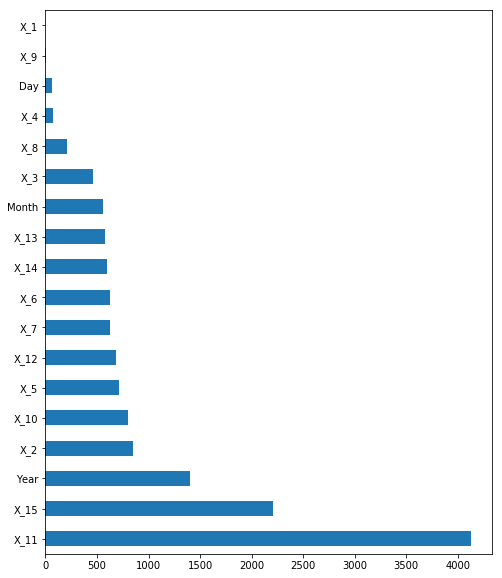

In [122]:
feat_imp = pd.Series(clf_final.feature_importances_, index=train_upsampled.drop(['MULTIPLE_OFFENSE'], 
                                                                                axis=1).columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

In [123]:
lgbm_pred = clf_final.predict(Xs_val, pred_contrib=False)
confusion_matrix(ys_val, lgbm_pred)

array([[6817,    0],
       [   9, 6847]], dtype=int64)

#### Final Params <a id = 'fp' ></a>

[Home](#home) <a href = '#home'></a>

In [124]:
final_params = {**gs.best_params_, **gs2.best_params_, **gs3.best_params_, **gs4.best_params_, **gs5.best_params_, 
               **gs6.best_params_, 'scoring':'recall', 'metric':'recall', 'objective': 'binary'}
final_params

{'cat_smooth': 13,
 'max_cat_threshold': 78,
 'min_data_per_group': 420,
 'learning_rate': 0.85,
 'num_iterations': 1169,
 'colsample_bytree': 0.5920465362447714,
 'min_child_samples': 119,
 'min_child_weight': 0.1,
 'num_leaves': 941,
 'max_bin': 666,
 'max_depth': 11,
 'min_data_in_leaf': 616,
 'boosting': 'dart',
 'reg_lambda': 4,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.8,
 'scoring': 'recall',
 'metric': 'recall',
 'objective': 'binary'}

In [125]:
recall_score(ys_val, lgbm_pred)

0.9986872812135356

In [126]:
test = test.drop(['MULTIPLE_OFFENSE', 'INCIDENT_ID'], axis = 1)
test['MULTIPLE_OFFENSE'] = clf_final.predict(test, pred_contrib=False)
test['INCIDENT_ID'] = testdf['INCIDENT_ID']

In [127]:
submission_lgbm = test[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission_lgbm.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [128]:
submission_lgbm.to_csv("submission_lgbm2.csv",index=False)